In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/BloodPressureDataset/part_4.mat
/kaggle/input/BloodPressureDataset/part_9.mat
/kaggle/input/BloodPressureDataset/part_10.mat
/kaggle/input/BloodPressureDataset/part_11.mat
/kaggle/input/BloodPressureDataset/part_3.mat
/kaggle/input/BloodPressureDataset/part_1.mat
/kaggle/input/BloodPressureDataset/part_8.mat
/kaggle/input/BloodPressureDataset/part_5.mat
/kaggle/input/BloodPressureDataset/part_6.mat
/kaggle/input/BloodPressureDataset/part_7.mat
/kaggle/input/BloodPressureDataset/part_2.mat
/kaggle/input/BloodPressureDataset/part_12.mat
/kaggle/input/BloodPressureDataset/Samples/rec_235.csv
/kaggle/input/BloodPressureDataset/Samples/rec_389.csv
/kaggle/input/BloodPressureDataset/Samples/rec_397.csv
/kaggle/input/BloodPressureDataset/Samples/rec_395.csv
/kaggle/input/BloodPressureDataset/Samples/rec_338.csv
/kaggle/input/BloodPressureDataset/Samples/rec_11.csv
/kaggle/input/BloodPressureDataset/Samples/rec_431.csv
/kaggle/input/BloodPressureDataset/Samples/rec_454.csv
/kaggl

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import tensorflow as tf
import pandas as pd
import os

In [3]:
os.chdir("..")
print(os.getcwd())
print(os.listdir())

/kaggle
['src', 'lib', 'input', 'working']


In [4]:
os.chdir("./input/BloodPressureDataset")

In [5]:
ecg =[]
bp_min = []
bp_max = []
sample_size  = 64
for i in range(6):
    data = scipy.io.loadmat(f"part_{i+1}.mat")['p']
    for i in range(1000):
        temp_mat = data[0 , i]
        temp_length = temp_mat.shape[1]
        for j in range((int)(temp_length/sample_size)):
            temp_ecg = temp_mat[2, j*sample_size:(j+1)*sample_size]
            temp_bp = temp_mat[1, j*sample_size:(j+1)*sample_size]
            ecg.append(temp_ecg)
            bp_min.append(np.min(temp_bp))
            bp_max.append(np.max(temp_bp))

In [6]:
res = pd.DataFrame({"data": ecg , "blood_presure_min":bp_min , "blood_presure_max":bp_max})
res.head()

,data,blood_presure_min,blood_presure_max
0,"[-0.06060606060606061, -0.07526881720430108, -...",67.062955,124.601310
1,"[-0.09530791788856305, -0.07038123167155426, -...",66.525670,123.038299
2,"[-0.10019550342130987, -0.045454545454545456, ...",65.597632,120.986846
3,"[0.024437927663734114, 0.06989247311827956, 0....",66.134917,118.349265
4,"[0.28005865102639294, 0.30009775171065495, 0.3...",66.134917,121.621820


In [7]:
res.shape

(2780422, 3)

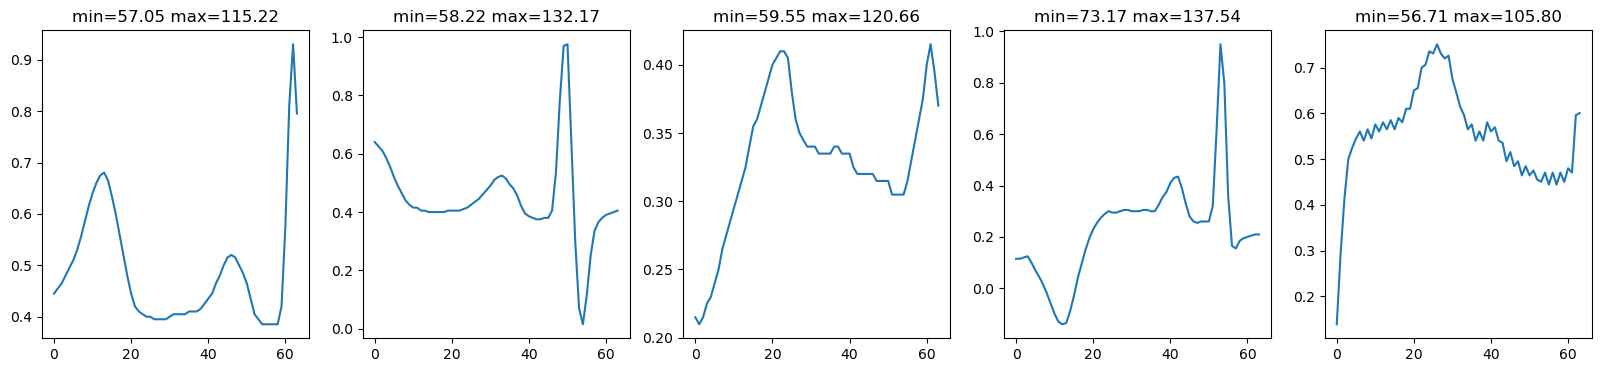

In [8]:
fig , axes = plt.subplots(1, 5 , figsize=(20,4))
axes = axes.flatten()
for i , j in enumerate(np.random.randint(0, 3e6,5)):
    ecg_plot = res.iloc[j, 0]
    bp_min_val = res.iloc[j,1]
    bp_max_val = res.iloc[j, 2]
    axes[i].plot(np.array(ecg_plot))
    axes[i].set_title(f"min={bp_min_val:0.2f} max={bp_max_val:0.2f}")
plt.savefig("/kaggle/working/sample_test.png", pad_inches=0,bbox_inches="tight")

In [9]:
res.describe(include=['number']).round().astype(int)#.to_csv("/kaggle/working/describe.csv",index=None)

,blood_presure_min,blood_presure_max
count,2780422,2780422
mean,68,126
std,12,25
min,50,54
25%,59,108
50%,66,124
75%,75,143
max,195,200


In [10]:
res = res.sample(2500000)

In [11]:
min_blood_mask = res['blood_presure_min'].between(55, 120, inclusive="both")
max_blood_mask = res['blood_presure_max'].between(90, 200, inclusive='left')
mask = np.logical_and(min_blood_mask , max_blood_mask)
mask.sum()

2124772

In [12]:
res = res[mask]
res.describe(include='number').round().astype(int)

,blood_presure_min,blood_presure_max
count,2124772,2124772
mean,70,130
std,11,22
min,55,90
25%,61,113
50%,68,128
75%,77,146
max,120,200


In [13]:
res.shape

(2124772, 3)

In [14]:
res.describe(include='number').round().astype(int).to_csv("/kaggle/working/describe_after.csv")

In [15]:
bp_max_set = np.array(res['blood_presure_max']).reshape(-1,1)
bp_max_set.shape

(2124772, 1)

In [16]:
bp_min_set = np.array(res['blood_presure_min']).reshape(-1,1)
bp_min_set.shape

(2124772, 1)

In [17]:
#get data 
ecgset = np.array(res['data'].to_list())
ecgset.shape

(2124772, 64)

In [18]:
#build model/

def conv_block(x , num_filters):
    x = tf.keras.layers.Conv1D(num_filters , kernel_size=3 , strides=1 ,padding="same")(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(num_filters , kernel_size=3 , strides=1 ,padding="same")(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x 

In [19]:
def res_block(x , filters, shortcut_filter):
    y = x 
    for i in filters:
        x = conv_block(x, i)
    x = tf.keras.layers.Dropout(0.4)(x)
    y = tf.keras.layers.Conv1D(shortcut_filter,kernel_size=1 ,padding='same')(y)
    y = tf.keras.layers.ReLU()(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Dropout(0.4)(y)
    res = tf.keras.layers.Add()([x, y])
    return res

In [20]:
def sequence_unit(x ,n_units):
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units , activation="tanh",return_sequences=True))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x 

In [21]:
def build_model():
    input_ = tf.keras.layers.Input(shape=(sample_size,1))
    y = sequence_unit(input_ , 64)
    y = tf.keras.layers.Dropout(0.5)(y)
    y = sequence_unit(y , 256)
    y = tf.keras.layers.Conv1D(256 ,kernel_size=1 , padding='same', activation="relu")(y)
    x = tf.keras.layers.Conv1D(filters=16 , kernel_size=3 , padding='same')(input_)
    x = res_block(x, [16, 16 , 32], 32)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = res_block(x , [32, 64, 64] , 64)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = res_block(x , [64 , 128, 128] , 128)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = res_block(x , [128,256,256] , 256)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = res_block(x , [256,256,256] , 256)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Concatenate()([x,y])
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    out1 = tf.keras.layers.Dense(1 , activation="relu",name ="min")(x)
    out2 = tf.keras.layers.Dense(1 , activation="relu",name ="max")(x)
    model = tf.keras.models.Model(inputs=[input_], outputs={"min":out1 , "max":out2})
    return model
    

In [22]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [23]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
class HyperLoss(tf.keras.losses.Loss):
    def __init__(self , threshold=4,**kwargs):
        self.threshold = threshold
        super(HyperLoss ,self).__init__(**kwargs)
    def call(self, y_true ,  y_pred):
        error = y_true - y_pred
        is_samll = tf.abs(error)<self.threshold
        square_loss = tf.square(error)/2.0
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2.0
        return tf.where(is_samll , square_loss , linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold":self.threshold}


In [25]:
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3) ,
                 loss=HyperLoss() , metrics=["mae"])
    

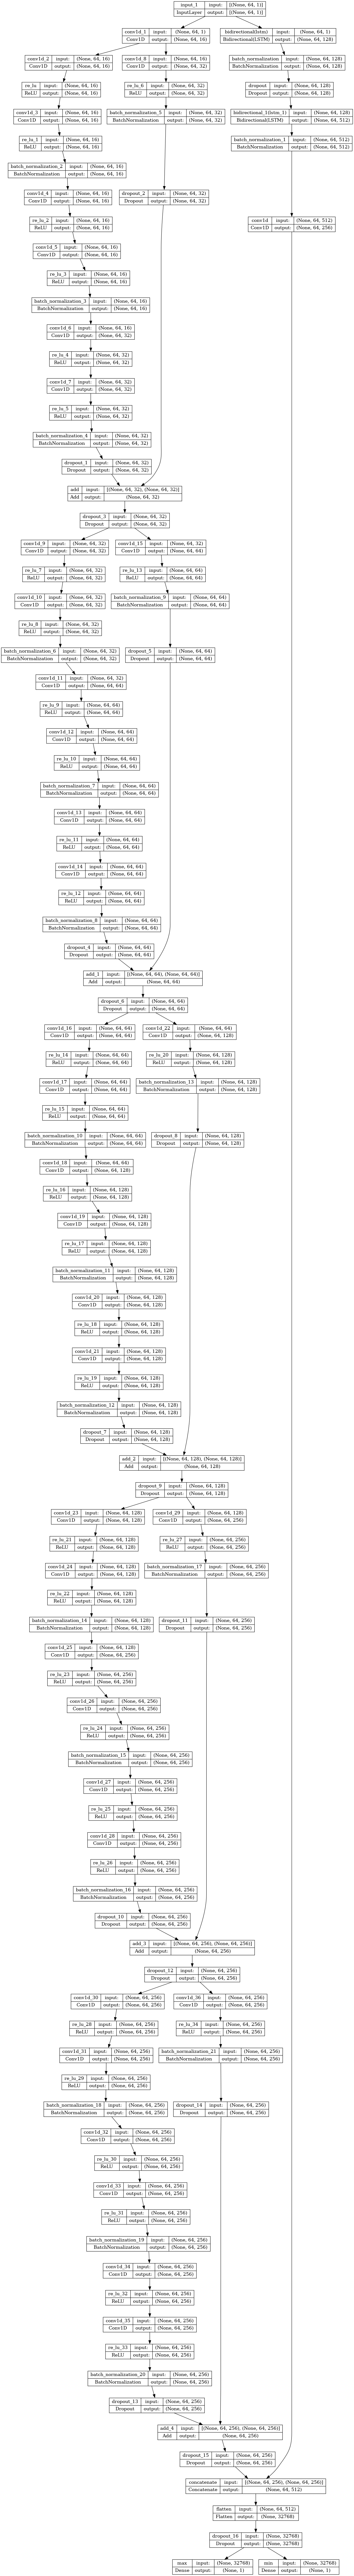

In [26]:
tf.keras.utils.plot_model(model , "/kaggle/working/model_arch.png", show_shapes=True ,
                         show_layer_names=True)

In [27]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, mode = "min") ,
               tf.keras.callbacks.ModelCheckpoint("/kaggle/working/model.h5", monitor="val_loss", save_best_only=True)]

In [28]:
ecgset_prep = ecgset.reshape(-1, 64 ,1)
ecgset_prep.shape

(2124772, 64, 1)

In [29]:
data_points = 1800000

In [30]:
data_points*0.01

18000.0

In [31]:
bp_min_set.shape

(2124772, 1)

In [32]:
%who

HyperLoss	 axes	 bp_max	 bp_max_set	 bp_max_val	 bp_min	 bp_min_set	 bp_min_val	 build_model	 
callbacks	 conv_block	 data	 data_points	 dirname	 ecg	 ecg_plot	 ecgset	 ecgset_prep	 
fig	 filename	 filenames	 i	 j	 mask	 max_blood_mask	 min_blood_mask	 model	 
np	 os	 pd	 plt	 res	 res_block	 sample_size	 scipy	 sequence_unit	 
temp_bp	 temp_ecg	 temp_length	 temp_mat	 tf	 


In [33]:
history = model.fit(ecgset_prep[:data_points] , y={"min":bp_min_set[:data_points] , "max":bp_max_set[:data_points]}, 
                        batch_size=256,epochs=30 ,
                        callbacks=callbacks , 
                        validation_split=0.01 ,
                   )

Epoch 1/30
6961/6961 [==============================] - 1062s 148ms/step - loss: 80.7089 - max_loss: 54.8585 - min_loss: 25.8503 - max_mae: 15.5943 - min_mae: 8.2383 - val_loss: 64.5713 - val_max_loss: 44.2603 - val_min_loss: 20.3111 - val_max_mae: 12.9159 - val_min_mae: 6.8155
Epoch 2/30
6961/6961 [==============================] - 1023s 147ms/step - loss: 59.9081 - max_loss: 40.7994 - min_loss: 19.1087 - max_mae: 12.0344 - min_mae: 6.4745 - val_loss: 53.0621 - val_max_loss: 35.8991 - val_min_loss: 17.1630 - val_max_mae: 10.7820 - val_min_mae: 5.9568
Epoch 3/30
6961/6961 [==============================] - 1023s 147ms/step - loss: 52.7954 - max_loss: 35.7567 - min_loss: 17.0389 - max_mae: 10.7506 - min_mae: 5.9232 - val_loss: 47.6536 - val_max_loss: 32.4262 - val_min_loss: 15.2274 - val_max_mae: 9.8971 - val_min_mae: 5.4223
Epoch 4/30
6961/6961 [==============================] - 1034s 149ms/step - loss: 48.9516 - max_loss: 33.0704 - min_loss: 15.8812 - max_mae: 10.0655 - min_mae: 5.613

In [34]:
history = pd.DataFrame(history.history)

In [35]:
history.head()

,loss,max_loss,min_loss,max_mae,min_mae,val_loss,val_max_loss,val_min_loss,val_max_mae,val_min_mae
0,80.708931,54.858524,25.850321,15.594260,8.238284,64.571327,44.260269,20.311056,12.915913,6.815454
1,59.908066,40.799412,19.108675,12.034359,6.474451,53.062111,35.899120,17.162998,10.782011,5.956790
2,52.795410,35.756668,17.038910,10.750618,5.923242,47.653553,32.426197,15.227354,9.897059,5.422280
3,48.951649,33.070431,15.881186,10.065514,5.613187,44.693310,30.329369,14.363933,9.352733,5.192799
4,46.429386,31.303446,15.125857,9.613292,5.409019,41.921047,28.336016,13.585022,8.838599,4.981206


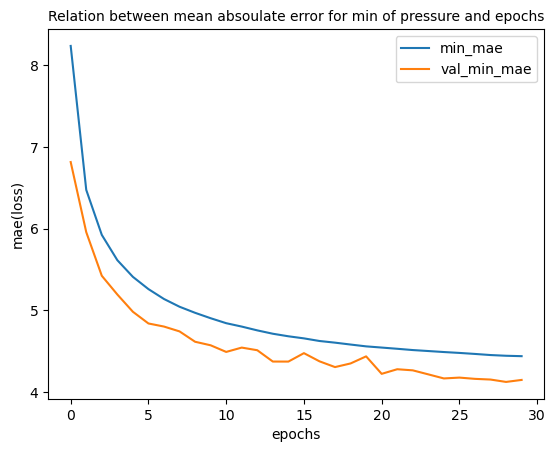

In [36]:
history[['min_mae',"val_min_mae"]].plot()
plt.xlabel("epochs")
plt.ylabel("mae(loss)")
plt.title("Relation between mean absoulate error for min of pressure and epochs",fontsize=10)
plt.savefig("/kaggle/working/min_mae.png",pad_inches=0 ,bbox_inches='tight')

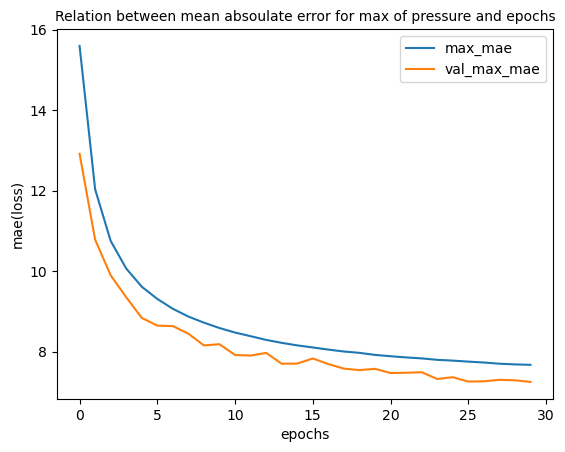

In [37]:
history[['max_mae',"val_max_mae"]].plot()
plt.xlabel("epochs")
plt.ylabel("mae(loss)")
plt.title("Relation between mean absoulate error for max of pressure and epochs",fontsize=10)
plt.savefig("/kaggle/working/max_mae.png",pad_inches=0 ,bbox_inches='tight')

In [38]:
ecg_test = ecgset_prep[sample_size:sample_size+10000]
min_true = bp_min_set[sample_size:sample_size+10000]
max_true = bp_max_set[sample_size:sample_size+10000]

In [39]:
new_model = tf.keras.models.load_model("/kaggle/working/model.h5",custom_objects={'HyperLoss':HyperLoss()})

In [40]:
pred = new_model(ecg_test)

In [41]:
min_pred = pred['min']
max_pred = pred['max']

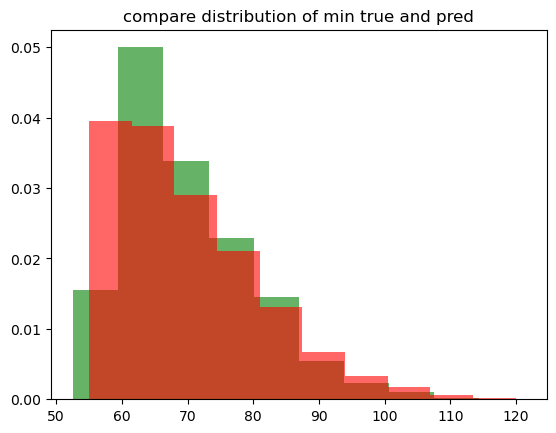

<Figure size 640x480 with 0 Axes>

In [42]:
fig,ax = plt.subplots(1,1)
ax.hist(min_pred.numpy(),color='g',alpha=0.6, label='min pred',density=True)
ax.hist(min_true , color ='r', alpha =0.6 , label='min true',density=True)
ax.set_title("compare distribution of min true and pred")
plt.show()
plt.savefig("/kaggle/working/dist_pf_min.png",pad_inches=0 ,bbox_inches='tight')

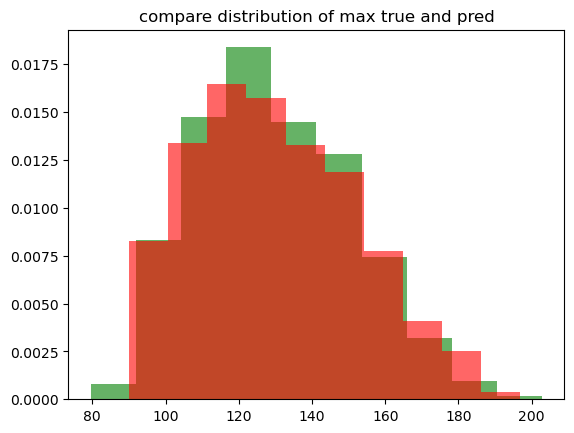

In [43]:
fig,ax = plt.subplots(1,1)
ax.hist(max_pred.numpy(),color='g',alpha=0.6, label='min pred',density=True)
ax.hist(max_true , color ='r', alpha =0.6 , label='min true',density=True)
ax.set_title("compare distribution of max true and pred")
plt.savefig("/kaggle/working/dist_pf_max.png",pad_inches=0 ,bbox_inches='tight')
plt.show()

In [44]:
error = np.abs(min_pred - min_true)
error.mean()

3.9807403

In [45]:
import shutil

In [46]:
shutil.make_archive('/kaggle/working/results', 'zip', '/kaggle/working')

'/kaggle/working/results.zip'

In [47]:
###########3try anthow updatwe for model 